## Homework


> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

### Dataset

In this homework, we will use the California Housing Prices data from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```
We'll keep working with the `'median_house_value'` variable, and we'll transform it to a classification task.

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`
* `'ocean_proximity'`,

### Data preparation

* Select only the features from above and fill in the missing values with 0.
* Create a new column `rooms_per_household` by dividing the column `total_rooms` by the column `households` from dataframe. 
* Create a new column `bedrooms_per_room` by dividing the column `total_bedrooms` by the column `total_rooms` from dataframe. 
* Create a new column `population_per_household` by dividing the column `population` by the column `households` from dataframe.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
df=pd.read_csv("../H2/housing.csv").fillna(0)
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

### Question 1

What is the most frequent observation (mode) for the column `ocean_proximity`?

Options:
* `NEAR BAY`
* `<1H OCEAN`
* `INLAND`
* `NEAR OCEAN`

In [17]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Split the data

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to 42.
* Make sure that the target value (`median_house_value`) is not in your dataframe.

In [18]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=42)
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
del df_train['median_house_value']
del df_val['median_house_value']

### Question 2

* Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your train dataset.
    - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

Options:
* `total_bedrooms` and `households`
* `total_bedrooms` and `total_rooms`
* `population` and `households`
* `population_per_household` and `total_rooms`

In [20]:
data_numeric=df_train.copy().drop(["ocean_proximity"],axis=1)

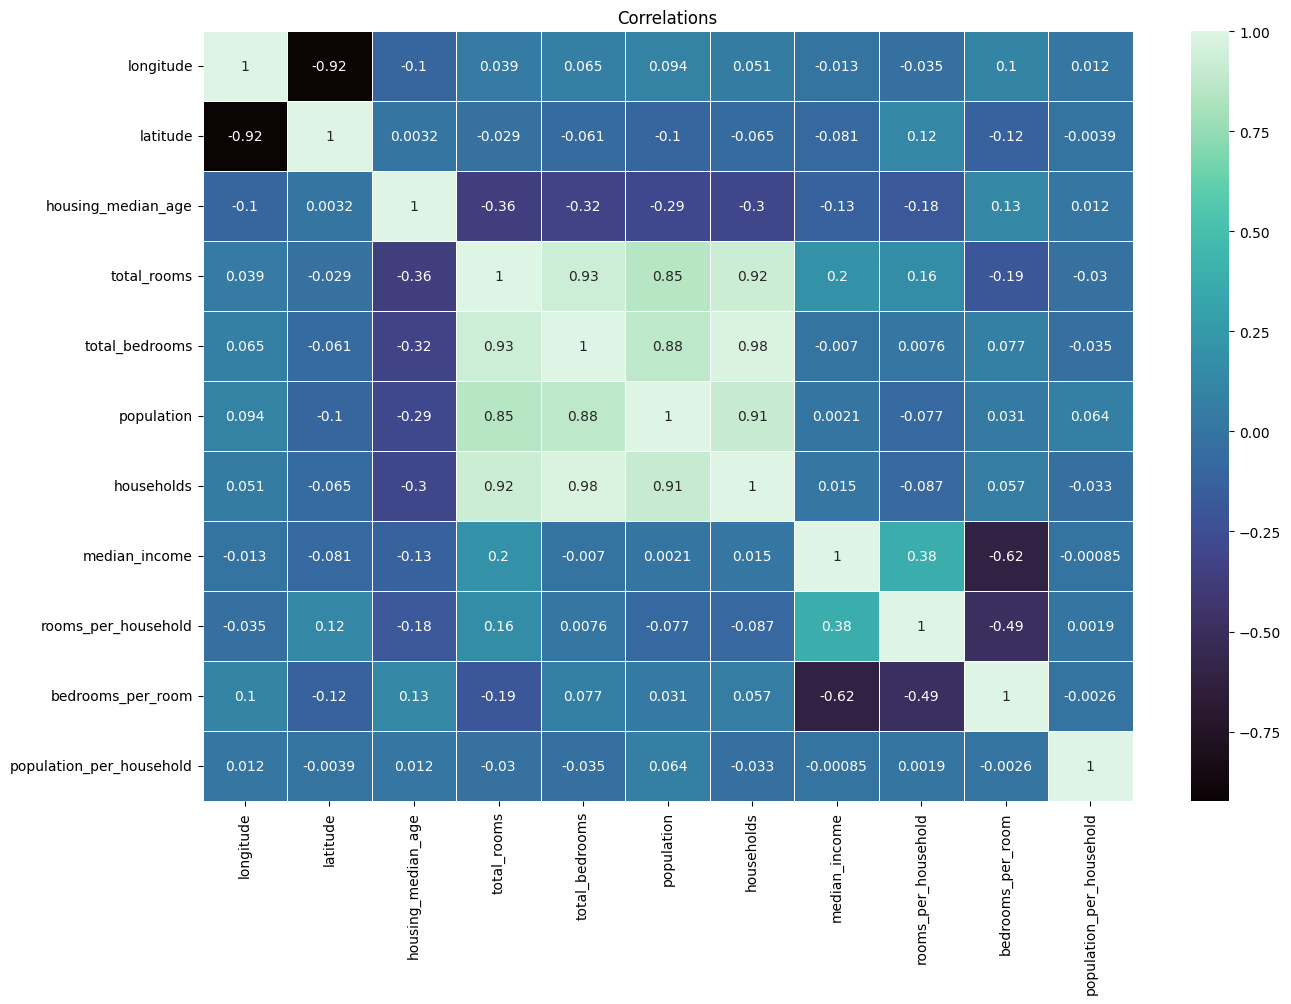

In [22]:
plt.figure(figsize=(15,10))  
sns.heatmap(data_numeric.corr(),annot=True,linewidths=.5, cmap="mako")
plt.title('Correlations')
plt.show()

In [43]:
data_numeric.corr().unstack().sort_values(ascending=False).drop_duplicates().head(5)

longitude       longitude         1.000000
total_bedrooms  households        0.979132
total_rooms     total_bedrooms    0.931785
households      total_rooms       0.920937
population      households        0.907327
dtype: float64

total_bedrooms            households

### Make `median_house_value` binary

* We need to turn the `median_house_value` variable from numeric into binary.
* Let's create a variable `above_average` which is `1` if the `median_house_value` is above its mean value and `0` otherwise.

In [71]:
above_average=(y_train>y_train.mean())
y_train_binary=(y_train>y_train.mean())
y_val_binary = (y_val>y_train.mean())

### Question 3

* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using `round(score, 2)`

Options:
- 0.263
- 0.00001
- 0.101
- 0.15555

In [72]:
score=mutual_info_score(df_train["ocean_proximity"],above_average)
round(score,3)

0.103

### Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable `ocean_proximity` in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

Options:
- 0.60
- 0.72
- 0.84
- 0.95

In [73]:
train_dict=df_train.to_dict(orient="records")
dv=DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train=dv.transform(train_dict)
model=LogisticRegression(solver="liblinear",C=1.0,max_iter=1000,random_state=42)
model.fit(X_train,y_train_binary)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [74]:
val_dict=df_val.to_dict(orient="records")
X_val=dv.transform(val_dict)

In [78]:

accuracy=(model.predict(X_val)==y_val_binary).mean()
print(round(accuracy,2))


0.83


### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 
* Which of following feature has the smallest difference? 
   * `total_rooms`
   * `total_bedrooms` 
   * `population`
   * `households`

> **note**: the difference doesn't have to be positive



In [88]:

features=df_train.columns.to_list()
differences={}
for c in features:
    subset = features.copy()
    subset.remove(c)
    
    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver="liblinear", C=1.0, random_state=42 ,max_iter=1000)
    model.fit(X_train, y_train_binary)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    new_accu = (y_val_binary== y_pred).mean()
    diff=accuracy - new_accu
    if abs(diff)<0.002:
        differences[c] = diff
        print(c, round(accuracy - new_accu,4), round(accuracy,4), round(new_accu,4))

total_rooms 0.0 0.8295 0.8295
total_bedrooms -0.0012 0.8295 0.8308
rooms_per_household 0.0009 0.8295 0.8286
bedrooms_per_room 0.0012 0.8295 0.8283
population_per_household 0.0 0.8295 0.8295


In [89]:
differences

{'total_rooms': 0.0,
 'total_bedrooms': -0.0012110202845897478,
 'rooms_per_household': 0.0009082652134423386,
 'bedrooms_per_room': 0.0012110202845897478,
 'population_per_household': 0.0}


### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column `'median_house_value'`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (`model = Ridge(alpha=a, solver="sag", random_state=42)`) on the training data.
* This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.

Options:
- 0
- 0.01
- 0.1
- 1
- 10


In [92]:
train_dict=df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [93]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [95]:
for i in [0,0.001,0.1,1,10]:
    model=Ridge(alpha=i,random_state=42, solver="sag")
    model.fit(X_train,np.log1p(y_train))
    
    y_pred = model.predict(X_val)
    
    accu= np.sqrt(mean_squared_error(y_pred,np.log1p(y_val)))
    print(i, round(accu,3))

0 0.523
0.001 0.523
0.1 0.523
1 0.523
10 0.523


## Submit the results

* Submit your results here: https://forms.gle/vQXAnQDeqA81HSu86
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is 26 September (Monday), 23:00 CEST.

After that, the form will be closed.
